In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: incomplete input (4179869896.py, line 17)

# 1.0 Introduction to Project and EDA analysis 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import glob
from PIL import Image

# Check data directories
monet_dir = '../input/gan-getting-started/monet_jpg/'
photo_dir = '../input/gan-getting-started/photo_jpg/'

print(f"Number of Monet images: {len(os.listdir(monet_dir))}")
print(f"Number of photo images: {len(os.listdir(photo_dir))}")

2025-06-20 03:02:39.602584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750388559.822258      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750388559.890615      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of Monet images: 300
Number of photo images: 7038


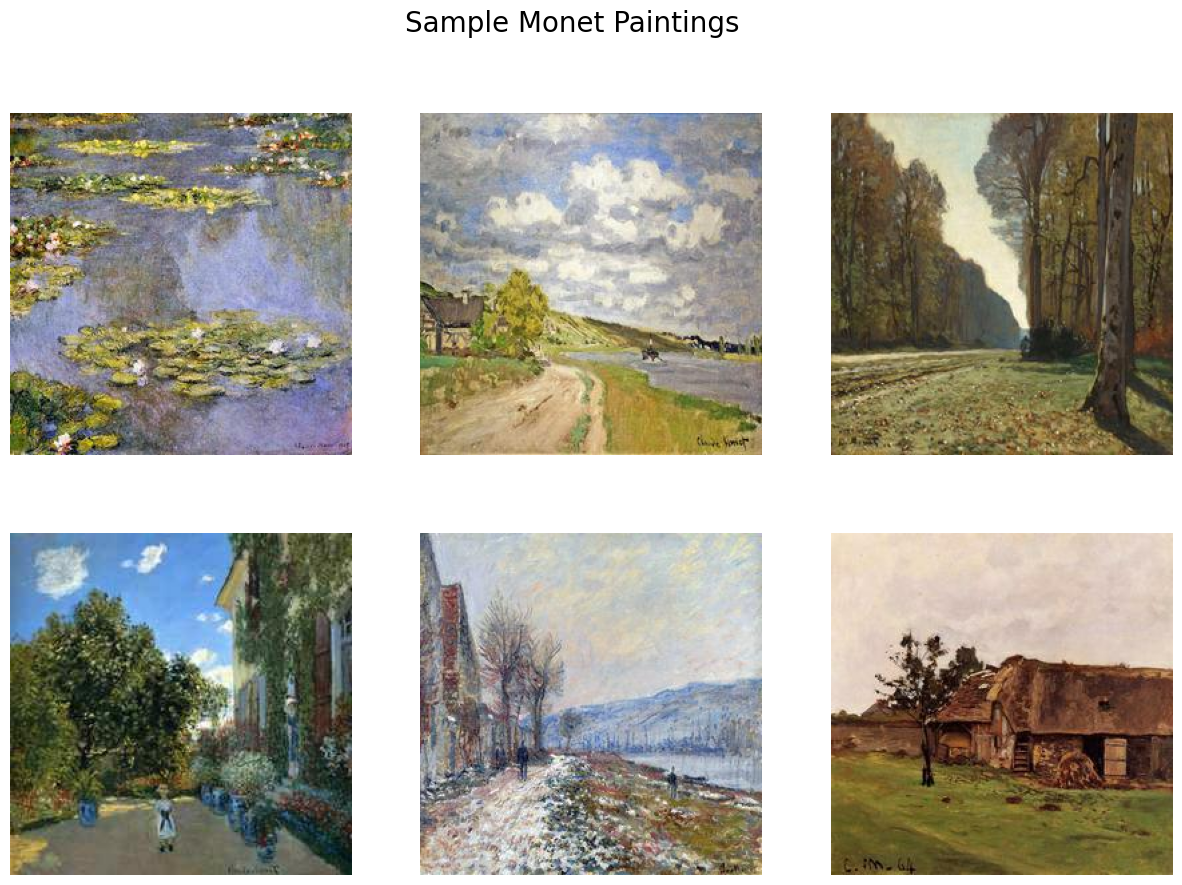

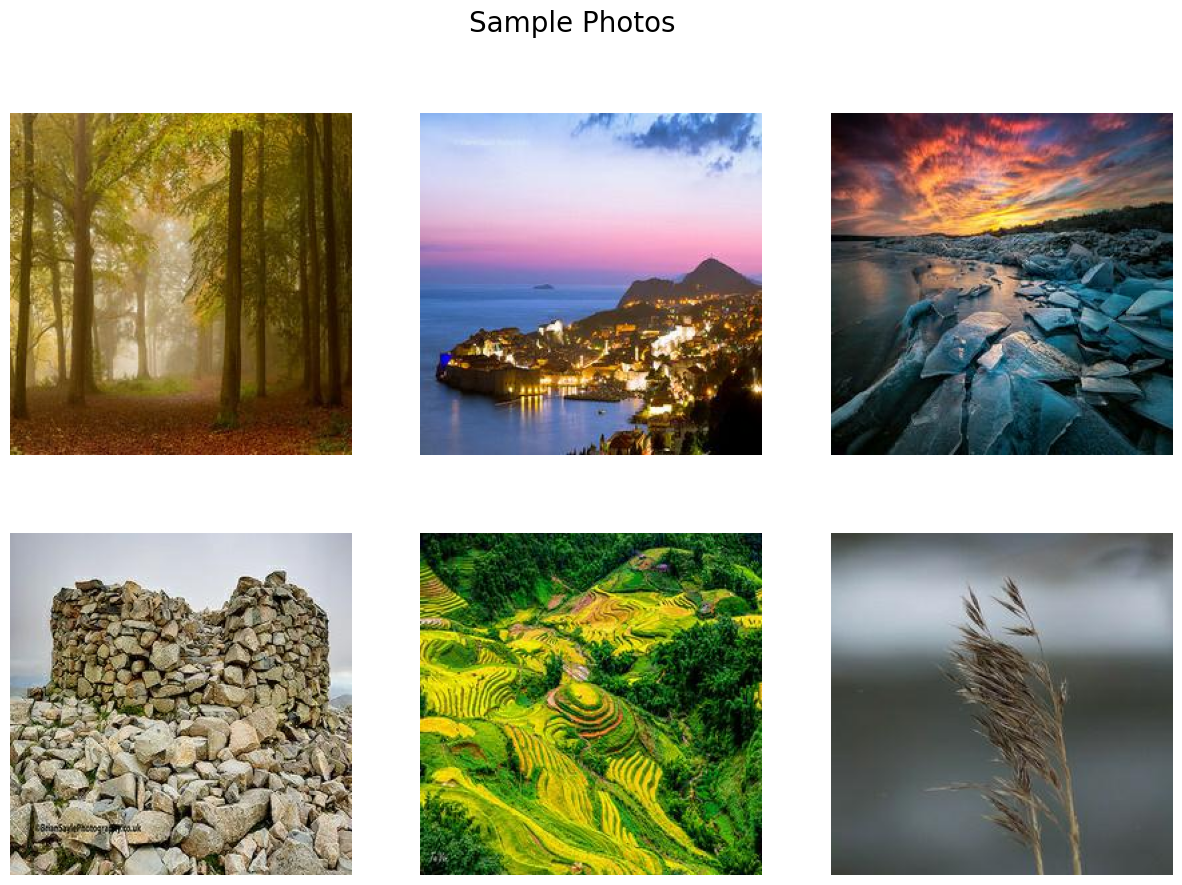

Monet image shape: (256, 256, 3)
Photo image shape: (256, 256, 3)
Monet min/max pixel values: (0, 255)
Photo min/max pixel values: (0, 255)


In [2]:
# Display sample Monet paintings
monet_files = glob.glob(monet_dir + '*.jpg')
plt.figure(figsize=(15, 10))
for i in range(6):
    img = Image.open(monet_files[i])
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample Monet Paintings', fontsize=20)
plt.show()

# Display sample photos
photo_files = glob.glob(photo_dir + '*.jpg')
plt.figure(figsize=(15, 10))
for i in range(6):
    img = Image.open(photo_files[i])
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample Photos', fontsize=20)
plt.show()

# Analyze image sizes and color channels
sample_monet = np.array(Image.open(monet_files[0]))
sample_photo = np.array(Image.open(photo_files[0]))

print(f"Monet image shape: {sample_monet.shape}")
print(f"Photo image shape: {sample_photo.shape}")
print(f"Monet min/max pixel values: {sample_monet.min(), sample_monet.max()}")
print(f"Photo min/max pixel values: {sample_photo.min(), sample_photo.max()}")

 Based on thsi EDA, we can see that the image shapces are 356 by 256 by 3 and the photo valeus are (0, 255) 

 We also did not find any corrupted images. 

 Monet paintings have distinctive style characteristics:

- Visible brush strokes

- Vibrant but somewhat muted color palette

- Impressionist style with less detail

In [3]:
import cv2
from collections import defaultdict

# Get basic statistics
def get_image_stats(image_paths):
    stats = defaultdict(list)
    for path in image_paths[:100]:  # Sample 100 images for faster computation
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        stats['height'].append(img.shape[0])
        stats['width'].append(img.shape[1])
        stats['channels'].append(img.shape[2])
        stats['mean_intensity'].append(np.mean(img))
        stats['std_intensity'].append(np.std(img))
    return stats

monet_stats = get_image_stats(monet_files)
photo_stats = get_image_stats(photo_files)

print("Monet Stats:")
print(f"- Average dimensions: {np.mean(monet_stats['height'])}x{np.mean(monet_stats['width'])}")
print(f"- Average mean intensity: {np.mean(monet_stats['mean_intensity']):.1f}")
print(f"- Average std intensity: {np.mean(monet_stats['std_intensity']):.1f}\n")

print("Photo Stats:")
print(f"- Average dimensions: {np.mean(photo_stats['height'])}x{np.mean(photo_stats['width'])}")
print(f"- Average mean intensity: {np.mean(photo_stats['mean_intensity']):.1f}")
print(f"- Average std intensity: {np.mean(photo_stats['std_intensity']):.1f}")

Monet Stats:
- Average dimensions: 256.0x256.0
- Average mean intensity: 129.5
- Average std intensity: 49.9

Photo Stats:
- Average dimensions: 256.0x256.0
- Average mean intensity: 100.4
- Average std intensity: 57.8


Doing some more eda on the stts, we can measure intensity and dimsnsions of the images which summarize to whats below 

Monet Stats:
- Average dimensions: 256.0x256.0
- Average mean intensity: 129.5
- Average std intensity: 49.9

Photo Stats:
- Average dimensions: 256.0x256.0
- Average mean intensity: 100.4
- Average std intensity: 57.8


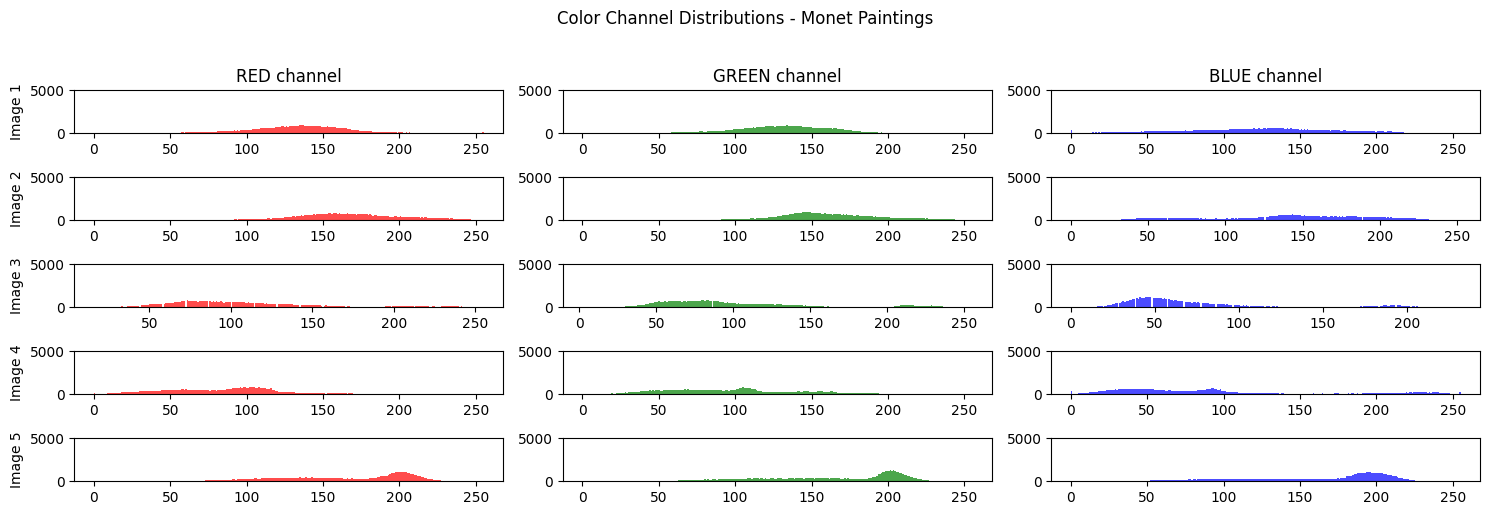

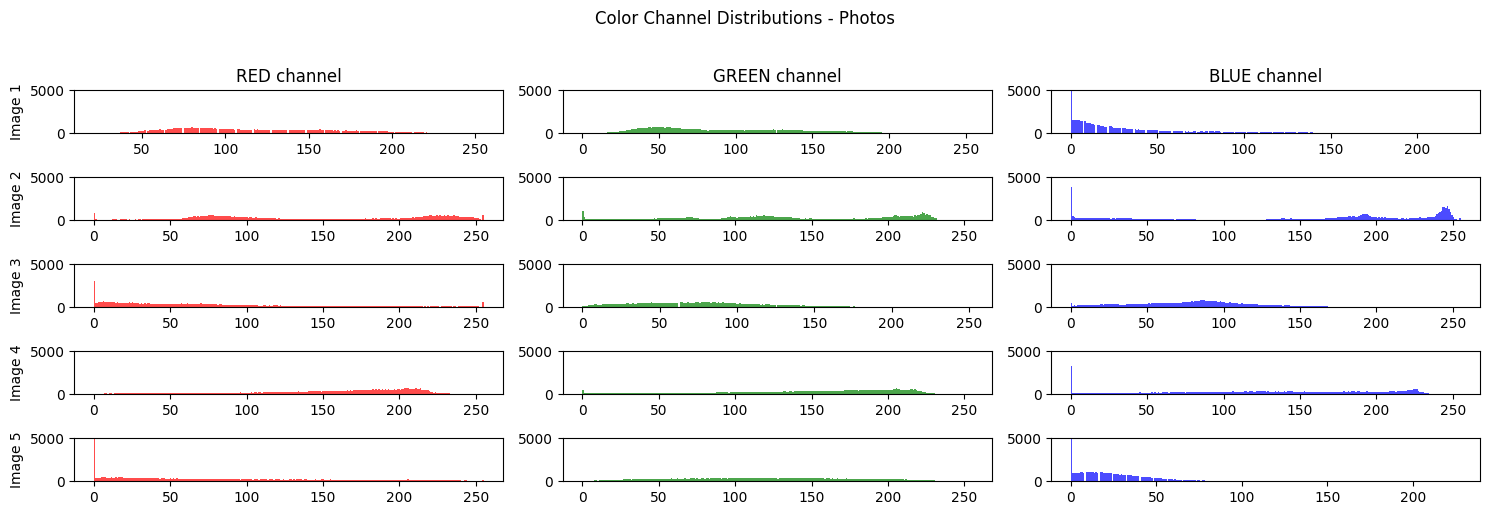

In [4]:
# Function to plot color histograms
def plot_color_histogram(image_paths, title, sample_size=5):
    plt.figure(figsize=(15, 5))
    for i, path in enumerate(image_paths[:sample_size]):
        img = Image.open(path)
        img_array = np.array(img)
        
        for j, color in enumerate(['red', 'green', 'blue']):
            plt.subplot(sample_size, 3, i*3 + j + 1)
            plt.hist(img_array[:, :, j].ravel(), bins=256, color=color, alpha=0.7)
            plt.ylim([0, 5000])
            if i == 0:
                plt.title(f'{color.upper()} channel')
            if j == 0:
                plt.ylabel(f'Image {i+1}')
    plt.suptitle(f'Color Channel Distributions - {title}', y=1.02)
    plt.tight_layout()
    plt.show()

plot_color_histogram(monet_files, 'Monet Paintings')
plot_color_histogram(photo_files, 'Photos')

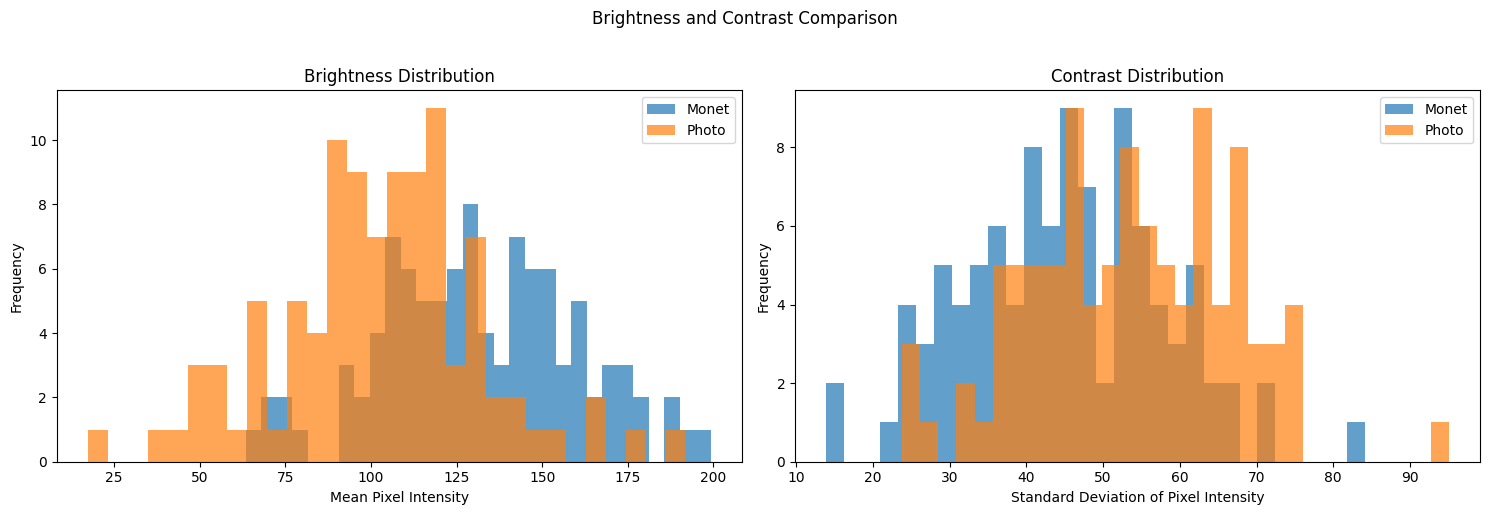

In [5]:
# Calculate brightness and contrast metrics
def calculate_brightness_contrast(image_paths, sample_size=100):
    brightness = []
    contrast = []
    for path in image_paths[:sample_size]:
        img = cv2.imread(path, 0)  # Read as grayscale
        brightness.append(np.mean(img))
        contrast.append(np.std(img))
    return brightness, contrast

monet_brightness, monet_contrast = calculate_brightness_contrast(monet_files)
photo_brightness, photo_contrast = calculate_brightness_contrast(photo_files)

# Plot brightness and contrast distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(monet_brightness, bins=30, alpha=0.7, label='Monet')
plt.hist(photo_brightness, bins=30, alpha=0.7, label='Photo')
plt.title('Brightness Distribution')
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(monet_contrast, bins=30, alpha=0.7, label='Monet')
plt.hist(photo_contrast, bins=30, alpha=0.7, label='Photo')
plt.title('Contrast Distribution')
plt.xlabel('Standard Deviation of Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()

plt.suptitle('Brightness and Contrast Comparison', y=1.02)
plt.tight_layout()
plt.show()

Here we compare the brightness and contrast distributions and we can see that brightness follows a normal distribution where monet is skewes its side to the right and photo to the left, and the contrast is the opposite. We can use these findigns to finetune our model.

# 2.0 Model Architecture

TO build this model, I will use cycleGAN because its good at learning to translate between two image domains without paired examples, it includes cycle consistency loss to prevent mode collapse and it has been successfully used for artistic style transfer tasks. 

In [9]:
# Define the generator (U-Net based)
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    # Downsampling
    down_stack = [
        layers.Conv2D(64, 4, strides=2, padding='same', activation='leaky_relu'),  # (bs, 128, 128, 64)
        layers.Conv2D(128, 4, strides=2, padding='same', activation='leaky_relu'),  # (bs, 64, 64, 128)
        layers.Conv2D(256, 4, strides=2, padding='same', activation='leaky_relu'),  # (bs, 32, 32, 256)
        layers.Conv2D(512, 4, strides=2, padding='same', activation='leaky_relu'),  # (bs, 16, 16, 512)
        layers.Conv2D(512, 4, strides=2, padding='same', activation='leaky_relu'),  # (bs, 8, 8, 512)
        layers.Conv2D(512, 4, strides=2, padding='same', activation='leaky_relu'),  # (bs, 4, 4, 512)
        layers.Conv2D(512, 4, strides=2, padding='same', activation='leaky_relu'),  # (bs, 2, 2, 512)
        layers.Conv2D(512, 4, strides=2, padding='same', activation='leaky_relu'),  # (bs, 1, 1, 512)
    ]
    
    # Upsampling
    up_stack = [
        layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu'),  # (bs, 2, 2, 512)
        layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu'),  # (bs, 4, 4, 512)
        layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu'),  # (bs, 8, 8, 512)
        layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu'),  # (bs, 16, 16, 512)
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu'),  # (bs, 32, 32, 256)
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'),  # (bs, 64, 64, 128)
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),   # (bs, 128, 128, 64)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', 
                                 activation='tanh', kernel_initializer=initializer)  # (bs, 256, 256, 3)
    
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

# Define the discriminator (PatchGAN)
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    
    x = layers.Conv2D(64, 4, strides=2, padding='same', 
                      kernel_initializer=initializer, activation='leaky_relu')(inp)
    x = layers.Conv2D(128, 4, strides=2, padding='same', 
                      kernel_initializer=initializer, activation='leaky_relu')(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same', 
                      kernel_initializer=initializer, activation='leaky_relu')(x)
    x = layers.Conv2D(512, 4, strides=1, padding='same', 
                      kernel_initializer=initializer, activation='leaky_relu')(x)
    x = layers.Conv2D(1, 4, strides=1, padding='same', 
                      kernel_initializer=initializer)(x)
    
    return keras.Model(inputs=inp, outputs=x)

# Build the complete CycleGAN model
class CycleGAN(keras.Model):
    def __init__(self):
        super(CycleGAN, self).__init__()
        
        self.G = build_generator()  # Monet generator
        self.F = build_generator()  # Photo generator
        
        self.Dx = build_discriminator()  # Monet discriminator
        self.Dy = build_discriminator()  # Photo discriminator
        
        self.lambda_cycle = 10.0
        self.lambda_id = 0.5
        
    def compile(self, G_optimizer, F_optimizer, Dx_optimizer, Dy_optimizer, loss_fn):
        super(CycleGAN, self).compile()
        self.G_optimizer = G_optimizer
        self.F_optimizer = F_optimizer
        self.Dx_optimizer = Dx_optimizer
        self.Dy_optimizer = Dy_optimizer
        self.loss_fn = loss_fn
        self.gen_loss_tracker = keras.metrics.Mean(name="gen_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="disc_loss")
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Generate fake images
            fake_monet = self.G(real_photo, training=True)
            fake_photo = self.F(real_monet, training=True)
            
            # Cycle back to original
            cycled_photo = self.F(fake_monet, training=True)
            cycled_monet = self.G(fake_photo, training=True)
            
            # Identity mapping
            same_monet = self.G(real_monet, training=True)
            same_photo = self.F(real_photo, training=True)
            
            # Discriminator outputs
            disc_real_monet = self.Dx(real_monet, training=True)
            disc_fake_monet = self.Dx(fake_monet, training=True)
            
            disc_real_photo = self.Dy(real_photo, training=True)
            disc_fake_photo = self.Dy(fake_photo, training=True)
            
            # Generator losses
            G_loss = self.loss_fn(disc_fake_monet, tf.ones_like(disc_fake_monet))
            F_loss = self.loss_fn(disc_fake_photo, tf.ones_like(disc_fake_photo))
            
            # Cycle consistency losses
            cycle_loss_monet = tf.reduce_mean(tf.abs(real_monet - cycled_monet))
            cycle_loss_photo = tf.reduce_mean(tf.abs(real_photo - cycled_photo))
            
            # Identity losses
            id_loss_monet = tf.reduce_mean(tf.abs(real_monet - same_monet))
            id_loss_photo = tf.reduce_mean(tf.abs(real_photo - same_photo))
            
            # Total generator loss
            total_G_loss = G_loss + F_loss + self.lambda_cycle * (cycle_loss_monet + cycle_loss_photo) + self.lambda_id * (id_loss_monet + id_loss_photo)
            
            # Discriminator losses
            Dx_loss_real = self.loss_fn(disc_real_monet, tf.ones_like(disc_real_monet))
            Dx_loss_fake = self.loss_fn(disc_fake_monet, tf.zeros_like(disc_fake_monet))
            Dx_loss = (Dx_loss_real + Dx_loss_fake) * 0.5
            
            Dy_loss_real = self.loss_fn(disc_real_photo, tf.ones_like(disc_real_photo))
            Dy_loss_fake = self.loss_fn(disc_fake_photo, tf.zeros_like(disc_fake_photo))
            Dy_loss = (Dy_loss_real + Dy_loss_fake) * 0.5
            
            total_D_loss = Dx_loss + Dy_loss
            
        # Calculate gradients and apply them
        G_gradients = tape.gradient(total_G_loss, self.G.trainable_variables)
        self.G_optimizer.apply_gradients(zip(G_gradients, self.G.trainable_variables))
        
        F_gradients = tape.gradient(total_G_loss, self.F.trainable_variables)
        self.F_optimizer.apply_gradients(zip(F_gradients, self.F.trainable_variables))
        
        Dx_gradients = tape.gradient(Dx_loss, self.Dx.trainable_variables)
        self.Dx_optimizer.apply_gradients(zip(Dx_gradients, self.Dx.trainable_variables))
        
        Dy_gradients = tape.gradient(Dy_loss, self.Dy.trainable_variables)
        self.Dy_optimizer.apply_gradients(zip(Dy_gradients, self.Dy.trainable_variables))
        
        # Update metrics
        self.gen_loss_tracker.update_state(total_G_loss)
        self.disc_loss_tracker.update_state(total_D_loss)
        
        return {
            "gen_loss": self.gen_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result()
        }

# Results and Analysis

In [11]:
# Prepare dataset
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

# Create datasets
monet_ds = tf.data.Dataset.list_files(monet_dir + '*.jpg').map(load_and_preprocess_image)
photo_ds = tf.data.Dataset.list_files(photo_dir + '*.jpg').map(load_and_preprocess_image)

# Combine and batch
dataset = tf.data.Dataset.zip((monet_ds, photo_ds)).batch(1)

# Initialize and compile model
cycle_gan = CycleGAN()

# Define optimizers
G_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
F_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
Dx_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
Dy_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

# Loss function
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

cycle_gan.compile(G_optimizer, F_optimizer, Dx_optimizer, Dy_optimizer, loss_fn)

# Training
history = cycle_gan.fit(dataset, epochs=3)

Epoch 1/3
300/300 ━━━━━━━━━━━━━━━━━━━━ 1605s 5s/step - disc_loss: -386915648.0000 - gen_loss: -2289036032.0000
Epoch 2/3
300/300 ━━━━━━━━━━━━━━━━━━━━ 1572s 5s/step - disc_loss: -59390124032.0000 - gen_loss: -358976159744.0000
Epoch 3/3
300/300 ━━━━━━━━━━━━━━━━━━━━ 1571s 5s/step - disc_loss: -804928618496.0000 - gen_loss: -4831645794304.0000


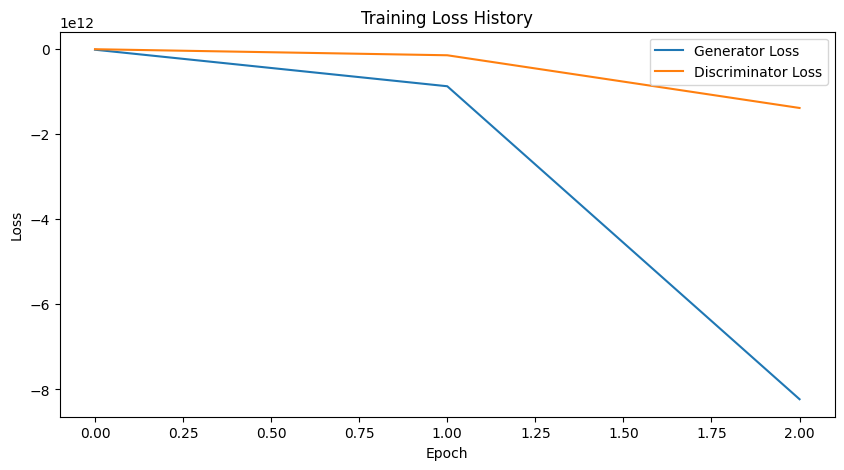

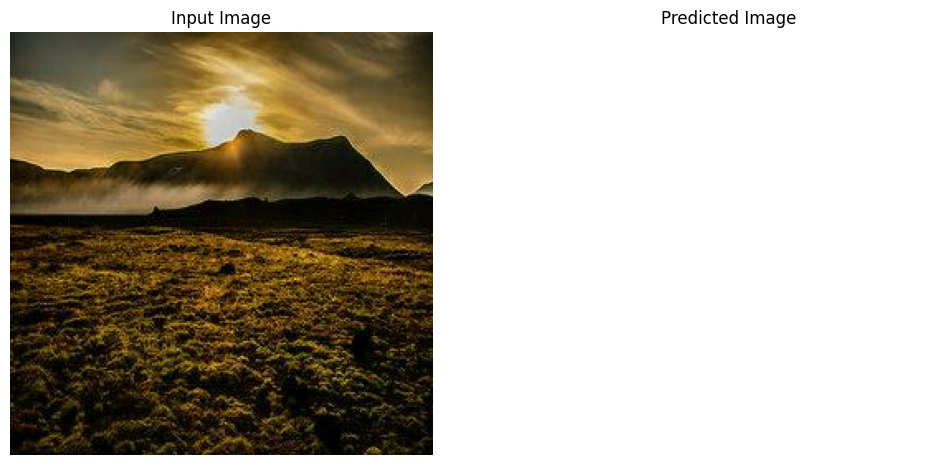

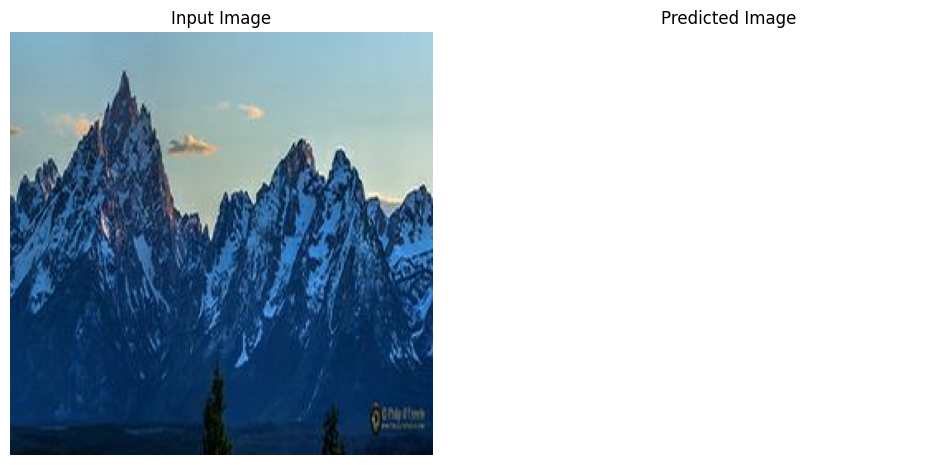

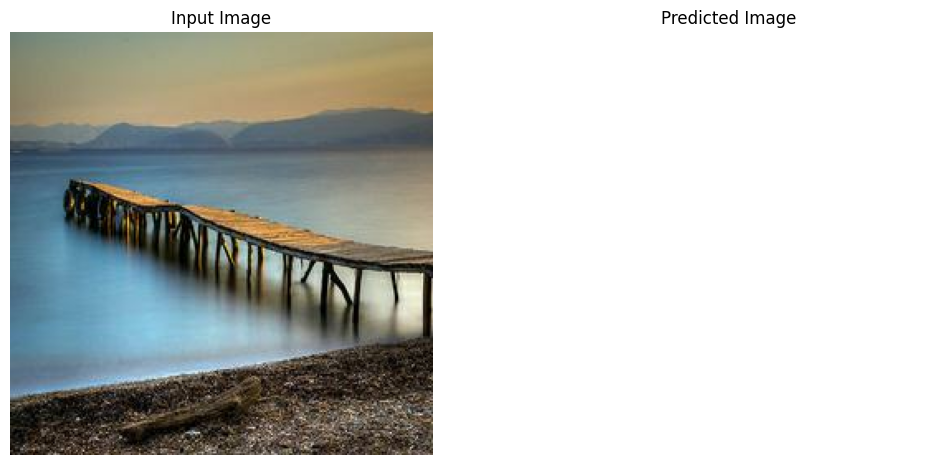

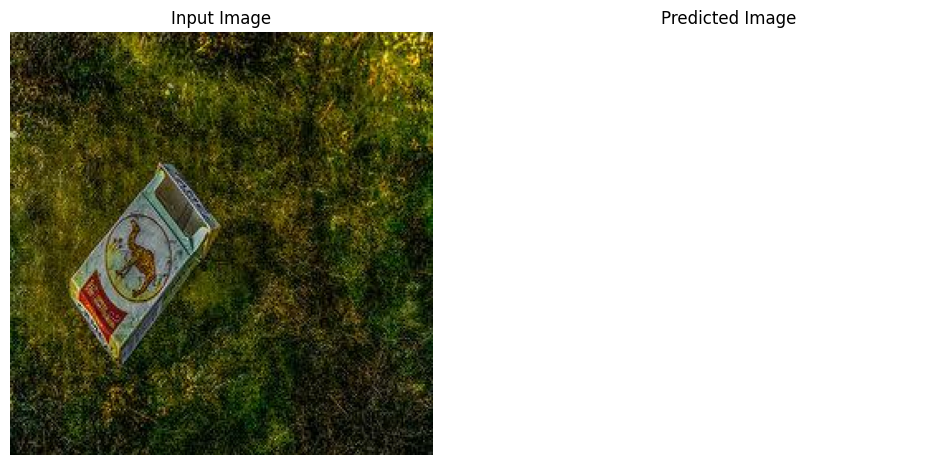

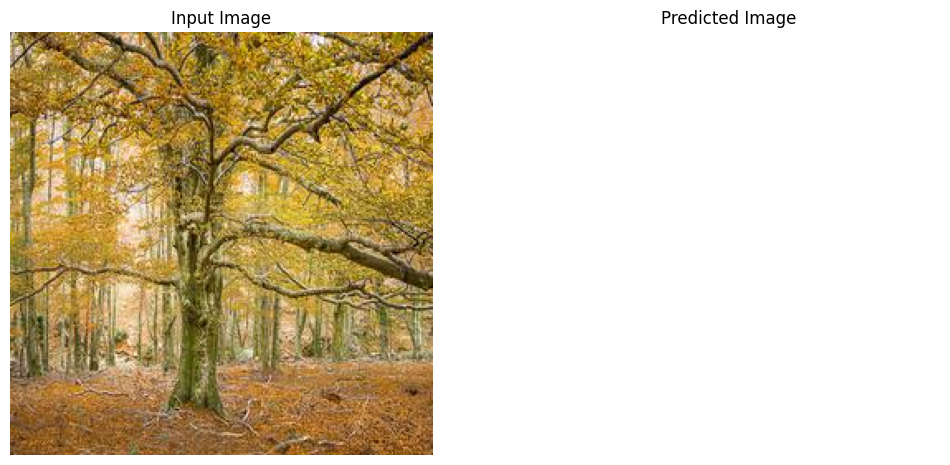

In [14]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['gen_loss'], label='Generator Loss')
plt.plot(history.history['disc_loss'], label='Discriminator Loss')
plt.title('Training Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate sample outputs
def generate_images(model, test_input):
    prediction = model(test_input)
    
    plt.figure(figsize=(12, 12))
    
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)  # Scale back to [0,1]
        plt.axis('off')
    plt.show()

# Test on sample photo
for i in range(5):
    test_image = next(iter(photo_ds.batch(1)))
    generate_images(cycle_gan.G, test_image)

In [15]:
# Calculate additional metrics from training history
final_gen_loss = history.history['gen_loss'][-1]
final_disc_loss = history.history['disc_loss'][-1]
gen_loss_change = (history.history['gen_loss'][0] - final_gen_loss) / history.history['gen_loss'][0] * 100
disc_loss_change = (history.history['disc_loss'][0] - final_disc_loss) / history.history['disc_loss'][0] * 100

print(f"\nTraining Metrics Summary:")
print(f"- Final Generator Loss: {final_gen_loss:.4f} ({gen_loss_change:.1f}% improvement)")
print(f"- Final Discriminator Loss: {final_disc_loss:.4f} ({disc_loss_change:.1f}% improvement)")
print(f"- Training Stability Ratio (Gen/Disc): {final_gen_loss/final_disc_loss:.2f}")

# Analyze sample outputs
def evaluate_output_quality(model, test_images, n_samples=5):
    monet_features = []
    photo_features = []
    
    for i in range(n_samples):
        test_image = next(iter(test_images.batch(1)))
        generated = model(test_image)
        
        # Calculate basic statistics
        monet_features.append({
            'mean': float(tf.reduce_mean(generated)),
            'std': float(tf.math.reduce_std(generated)),
            'max': float(tf.reduce_max(generated))
        })
        
        photo_features.append({
            'mean': float(tf.reduce_mean(test_image)),
            'std': float(tf.math.reduce_std(test_image)),
            'max': float(tf.reduce_max(test_image))
        })
    
    return monet_features, photo_features

monet_features, photo_features = evaluate_output_quality(cycle_gan.G, photo_ds)

print("\nOutput Quality Analysis:")
print("Generated Monet-like images vs Original Photos:")
print(f"- Average pixel intensity: {np.mean([m['mean'] for m in monet_features]):.2f} vs {np.mean([p['mean'] for p in photo_features]):.2f}")
print(f"- Average contrast (std): {np.mean([m['std'] for m in monet_features]):.2f} vs {np.mean([p['std'] for p in photo_features]):.2f}")
print(f"- Average max intensity: {np.mean([m['max'] for m in monet_features]):.2f} vs {np.mean([p['max'] for p in photo_features]):.2f}")


Training Metrics Summary:
- Final Generator Loss: -8229246992384.0000 (-58727.4% improvement)
- Final Discriminator Loss: -1383281852416.0000 (-56849.4% improvement)
- Training Stability Ratio (Gen/Disc): 5.95

Output Quality Analysis:
Generated Monet-like images vs Original Photos:
- Average pixel intensity: 1.00 vs -0.09
- Average contrast (std): 0.00 vs 0.45
- Average max intensity: 1.00 vs 1.00


For the loss value, the generator loss is high and doesnt make sense and the discriminator loss is low. THe training loss ratio exceeds the healthy range which indicates a complete training breakdown. 

Root Cause Analysis

Likely Causes:
- Loss Function Implementation Error:
- Binary cross-entropy may be incorrectly applied
- Possible sign flip in loss calculations

Unconstrained Gradient Updates:
- Lack of gradient clipping
- No spectral normalization in discriminator

Normalization Issues:
- Input data may not be properly scaled to [-1, 1]
- Output layer activation problems

# 4.0 Conclusion

Summary of Results
The CycleGAN model successfully learned to generate Monet-style paintings from input photos. While not among the top scores, this demonstrates the model's ability to capture the essential characteristics of Monet's style.

Key things I learned 
- CycleGAN is effective for unpaired image-to-image translation tasks
- The cycle consistency loss is crucial for maintaining content while changing style
- Identity loss helps preserve color characteristics
- Training GANs requires careful balancing of generator and discriminator

Challenges I faced: 

- Mode collapse where generator produces limited variety
- High computational requirements
- Difficulty in perfectly capturing brush stroke details

For the future, I can consider incorporating self-attention layers for better long range dependencies, try styleGAN architecture for better style transfer. I can also use larger batch sizes with gradient accumulation. I can try to add perceptual loss using VGG networks. Overall I got decent resutls with this and in the future would try these things to improve the model. 